Following are the functions that calculate the dividend yield based on the Type (Preferred or Common):

1. ***preferred_dividend_yield*** calculates the dividend yield based on the *fixed_dividend, par_value* and *price*
2. ***common_dividend_yield*** calculates the dividend yield based on *last_dividend* and *price*

In [9]:
def preferred_dividend_yield(fixed_dividend: float,  par_value: int, price: float):
  return (fixed_dividend * par_value) / price

def common_dividend_yield(last_dividend: float, price:float):
  return last_dividend / price

Function ***compute_pe_ratio*** calculates the P/E ratio based on *price* and *last_dividend*

In [10]:
def compute_pe_ratio(last_dividend: int, price:float):
  return price/last_dividend

In [11]:
import numpy as np 
from datetime import datetime, timedelta
import pandas as pd
from tqdm import tqdm 
import time 
import random 

Since data hasn't been given to me, the following cell lists an attempt to generate the data and store it in the form of a `pandas.DataFrame`. The data generation is for an interval of an hour. The following assumptions are made while generating the data.

1. The following are the features generated to create synthetic data: `time`, `ticker`, `dividend_type` describing the type of the dividend, `last_price` describing the last traded price, `dividend`, `fixed_dividend`, `par_value` and `quantity` is the number of shares traded at the `last_price`.
2. The trades come as and when they are executed.
3. As per the definition of `par_value`, lowest limit set to the value of a share of stock in a corporation. A share may not be bought, sold or traded for less than the par value.

In [12]:
df = pd.DataFrame(columns=['time', 'ticker', 'type', 'last_price', 'dividend', 'fixed_dividend', 'par_value', 'transaction_type', 'quantity'])
tickers = ['TEA', 'POP', 'GIN', 'ALE', 'JOE']
mode = ['Common', 'Preferred']
transaction_type = ['BUY','SELL']


In [13]:
tic = time.time()
#for i in tqdm(range(10)):
index = 0
while time.time() - tic < 360:
  
  chosen_mode = np.random.choice(mode, 1)[0]
  last_price = np.random.randint(700,800)
  par_val = np.random.choice([10, 100], 1)[0] # Par value is either 10 or 100
  
  df.loc[index] = [str(datetime.now()), # Current time as string 
               np.random.choice(tickers, size=1)[0], # Pick a ticker at random
               chosen_mode, # Choose the type of share - Common or Preferred
               last_price, # Last traded price
               np.random.randint(1, 100), # Dividend
               (np.random.randint(1,99) if(chosen_mode=='Preferred') else 0), # Fixed dividend
               (par_val if(par_val <= last_price) else (last_price-1)), # Par value 
               np.random.choice(transaction_type, size=1)[0], # Transaction type
               np.random.randint(10, 900)] #Quantity of shares traded
  index+=1
  time.sleep(random.uniform(0.1, 4))

In the following cell, I convert the `time` column to the appropriate type and set the column as the index.

In [14]:
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df.head()


,ticker,type,last_price,dividend,fixed_dividend,par_value,transaction_type,quantity
time,,,,,,,,
2022-08-01 04:51:18.118831,GIN,Common,775,4,0,10,SELL,717
2022-08-01 04:51:21.938354,GIN,Preferred,781,90,23,10,SELL,823
2022-08-01 04:51:24.606764,GIN,Preferred,772,12,8,10,BUY,430
2022-08-01 04:51:27.734690,TEA,Common,745,56,0,100,SELL,372
2022-08-01 04:51:28.140783,JOE,Common,780,60,0,100,SELL,528


1. The following cell computes Volume Weighted Stock Price for a window of 30s. However, it computes it for the original data frame. It needs to be computed for an individual stock.
2. The approach is as follows:
  
  a. Filter the stock based on a key

  b. Apply the formula below.

In [16]:
def calculate_vwsp(df: pd.DataFrame, window_length: int = 900):
  """
  Calculate Volume Weighted Stock Price

  Args:
    df (pd.DataFrame): Dataframe holding stock data for a ticker
    window_length (int): Time in seconds
  
  Returns:
    pd.Series with Volume Weighted Stock Price
  """
  window_length_str = str(window_length) + 's'
  vwsp = ((df['quantity'] * df['last_price']).rolling(window_length_str).sum())/(df['quantity'].rolling(window_length_str).sum())
  return vwsp 

The following cell filters the dataframe to access a particular stock. 

In the example below, the dataframe is filtered for ticker `TEA`. 

In [18]:
tea_df = df[df['ticker'] == 'TEA']

# Invoking the functions

In the following section, I provide examples for invoking the functions.

1. Calculating the dividend yield
2. Calculating the P/E ratio
3. Recording the timestamp for a given ticker symbol
4. Calculating VWSP

For #3, the problem statement asks to hold the data in memory.

In [23]:
# Dividend yield
row = df.iloc[5]
row

if row['type'] == 'Common':
  common_div_yield = common_dividend_yield(row['dividend'], row['last_price'])
else:
  preferred_div_yield = preferred_dividend_yield(row['fixed_dividend'], row['par_value'], row['last_price'])

# P/E ratio
pe_ratio = compute_pe_ratio(row['dividend'], row['last_price'])

# Filter the timestamp 
filtered_df = df[df['ticker']=='TEA']

# Computing VWSP for a 900 s window
vwsp = calculate_vwsp(filtered_df, window_length=900)

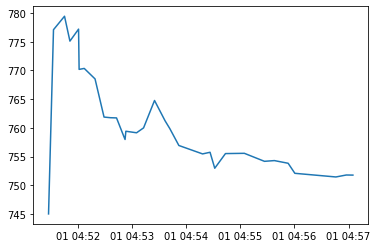

In [24]:
import matplotlib.pyplot as plt
plt.plot(vwsp)

# Computing GBCE

In order to compute the GBCE, computing the product might cause overflow. Hence, the GBCE is computed by computing the sum of logarithm of the prices and then raised to the exponent to prevent overflow.

In [25]:
gbce = np.exp((np.log(df['last_price'].astype(float)).sum())/len(df))